Exercício baseado no problema publicado no Kaggle: https://www.kaggle.com/sakshigoyal7/credit-card-customers

**Objetivo:** desenvolver um modelo de classificação capaz de identificar os clientes de cartão de créditos propensos a cancelarem este serviço.

**Proposta:**
- Efetuar uma análise exploratória dos dados do dataset
- Identificar possíveis enviesamento dos dados
- Realizar testes de hipóteses analisando a variância dos dados
- Testes de normalidade
- Identificar possíveis correlações
- Se necessário, aplicar técnicas de geração de amostras artificiais
- Aplicar técnicas de amostragem que diminuam ao máximo um possível overfitting
- Aplicar técnicas de normalização e regularização, onde aplicável
- Descobrir qual algoritmo tem o melhor desempenho entre Naïve Bayes, Regressão Logística, Árvore de decisão, Floresta Aleatória e SVC
- Usar técnicas de validação cruzada
- Validar resultado com matriz de confusão
- Analisar o grau de variação entre os resutados de teste

Contato pelo Linkedin: https://bit.ly/3tsOnU3

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import math
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.stats import shapiro
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()

# 1. Obtém o dataset através da API do Kaggle

In [2]:
parquet_file = "bancChurners.parquet"
csv_file = "BankChurners.csv"
zip_file = "credit-card-customers.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Obtém o dataset compactado em .zip, 
    extrai o arquivo .csv,
    deleta o arquivo .zip
    carrega o arquivo no jupyter,
    deleta o arquivo .csv,
    e gera um arquivo .parquet
    """
    print ("There is no file")
    !kaggle datasets download -d sakshigoyal7/credit-card-customers
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(zip_file)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset.head()

There is a parquet file!!!


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# 2. Análise Exploratória dos Dados

In [3]:
dataset.shape

(10127, 23)

**nota:** de acordo com o post deste dataset no Kaggle, é necessário deletar as últimas duas colunas.

In [4]:
dataset.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis=1, inplace=True)
dataset.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis=1, inplace=True)
dataset.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


**análise:** através do resultado "false" obtido abaixo, foi provado que:
- Todos os elementos possuem todos os dados, portanto não se faz necessário a remoção de nenhum deles da base de dados, bem como não se faz necessário utilizar nenhuma técnica de preenchimento de dado (ex.: interpolação, média, moda e etc.).
- Não há colunas com excesso de dados nulos, portanto, se for necessário eliminar alguma coluna, não será por este motivo, mas simpor algum outro como baixa correlação com a variável de resposta.

In [5]:
dataset.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

**análise:** abaixo é possível notar que entre as variáveis explicativas existem variáveis qualitativas, do tipo "object", e variáveis quantitativas, do tipo int64 (discreta) e float64 (contínua). E mais abaixo, é evidenciado a necessidade da normalização das variáveis explicativas quantitativas.

In [6]:
dataset.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [7]:
dataset.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


**análise:** a coluna da variável de resposta, 'Attrition_Flag', não está equilibradamente balanceada entre as duas classes fornecidas. Portanto, pode ser necessário utilizar técnicas para remover ou criar elementos artificiais devido ao desbalanceamento entre as classes.

In [8]:
np.unique(dataset['Attrition_Flag'], return_counts=True)

(array(['Attrited Customer', 'Existing Customer'], dtype=object),
 array([1627, 8500], dtype=int64))

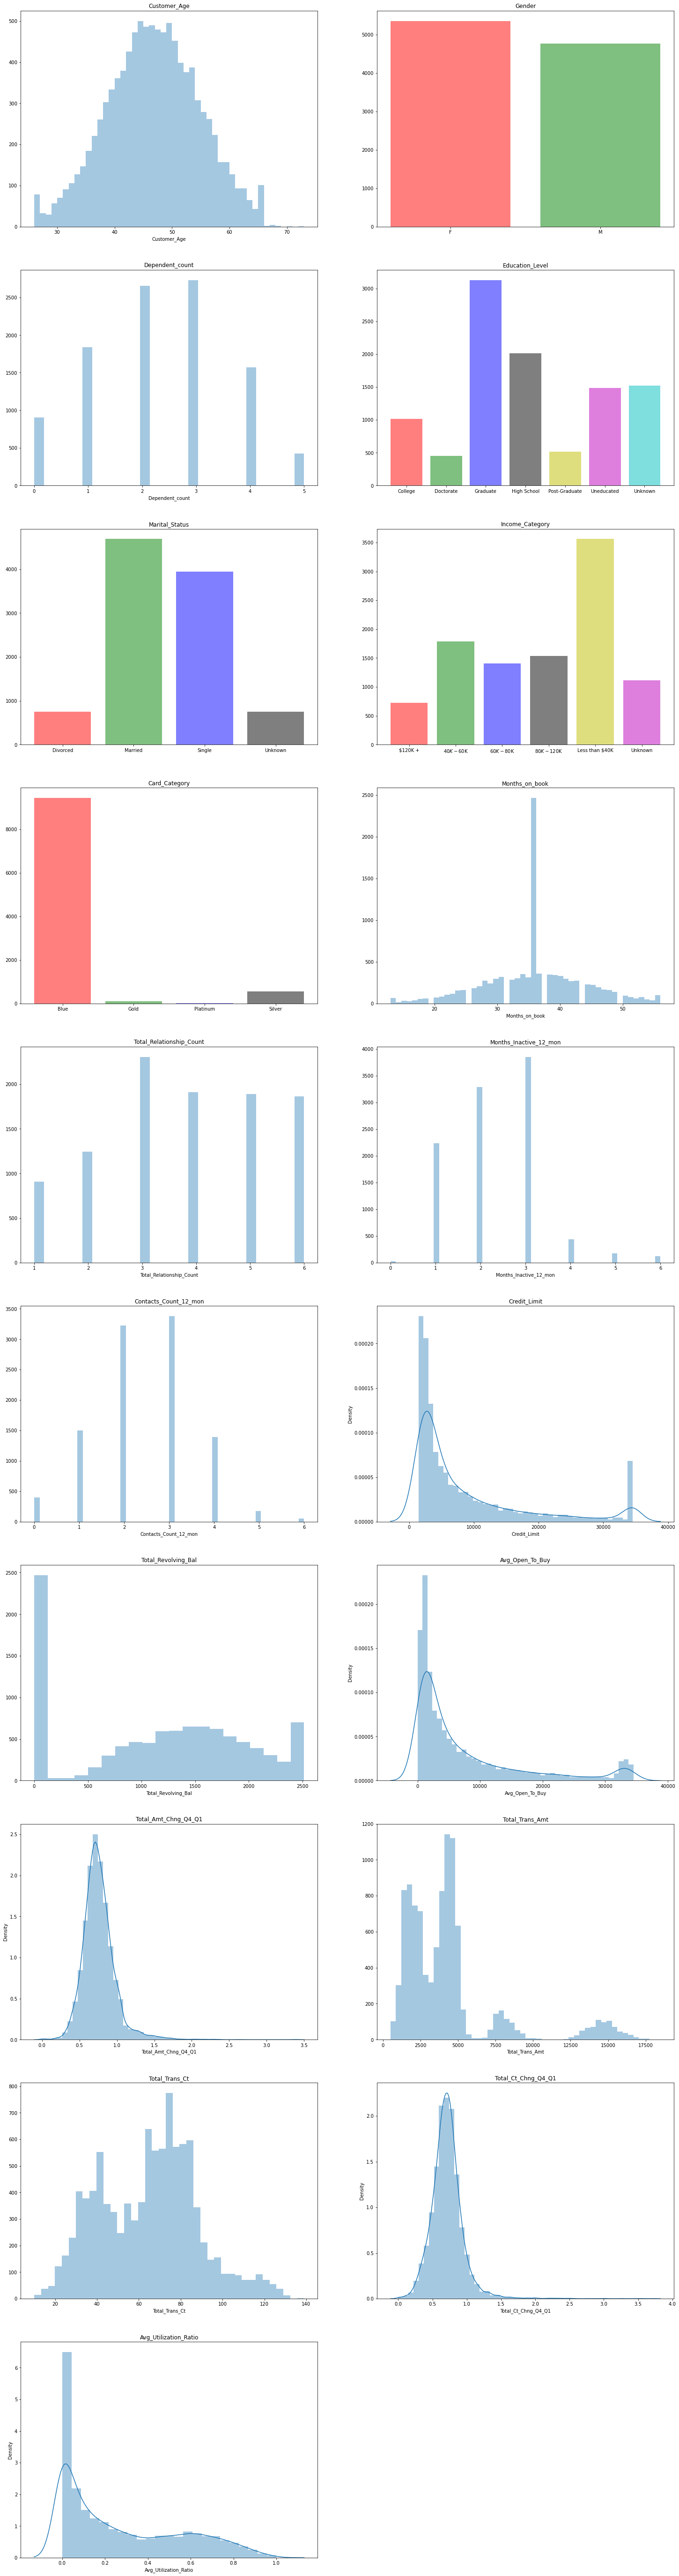

In [211]:
qtd_colunas_subplot = 2
qtd_linhas_subplot = math.ceil(len(dataset.iloc[:,2:].columns)/qtd_colunas_subplot)

_, ax = plt.subplots(qtd_linhas_subplot, qtd_colunas_subplot, figsize=(25,100))

for count, column in enumerate(dataset.iloc[:,2:].columns):
    current_ax = ax[count//qtd_colunas_subplot][count%qtd_colunas_subplot]
    current_ax.set_title(column)
    if dataset[column].dtype in ["int64", "float64"]:
        kde = True if dataset[column].dtype == "float64" else False
        sns.distplot(dataset[column], kde=kde, ax=current_ax)
    else:
        data = pd.DataFrame(dataset[column].groupby(dataset[column]).size().reset_index(name='Quantidade'))
        #Lição do dia: existe um bug ao usar o barplot nos subplots do MatPlotLib que 
        #o impede de renderizar o gráfico no grid do subplot, então só é possível usar o stripplot
        #que não é tão legal
        # sns.stripplot(x=column, y='Quantidade', data=data, ax=current_ax, size=15, orient="v", marker="h")
        current_ax.bar(x=column, height='Quantidade', data=data, color='rgbkymc', alpha=0.5)
        
# Deletar os frames vazios
qtd_frames_vazios = qtd_colunas_subplot*qtd_linhas_subplot - len(dataset.iloc[:,2:].columns)
[ax.flat[-i].set_visible(False) for i in range(1, qtd_frames_vazios+1)]
plt.show()
plt.close()

In [ ]:
!jupyter nbconvert --to html --output "notebook_file" "credit_card.ipynb" --no-input